In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.utils import Progbar
from utils import make_dataset, get_data, preprocess
from models import models
from config import CONFIG
import tensorflow as tf
from IPython import display
import os

In [ ]:
train_images, train_labels = get_data("digit_mnist")
train_images = preprocess(train_images, "digit_mnist")
train_ds = make_dataset(train_images)

In [ ]:

generator = models.get_generator()
discriminator = models.get_discriminator()

gen_optimizer = tf.keras.optimizers.Adam(1e-4)
disc_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.losses.BinaryCrossentropy(from_logits=True)
img_seed = tf.random.normal([CONFIG.num_examples, CONFIG.latent_dim])

In [ ]:
ckpt_dir = "./checkpoints"
ckpt_prefix = os.path.join(ckpt_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
    generator=generator,
    discriminator=discriminator,
    generator_optimizer=gen_optimizer,
    discriminator_optimizer=disc_optimizer
)


Epoch [50/50]
70144/70000 [==============================] - 12s 173us/step


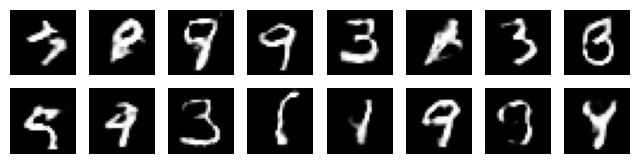

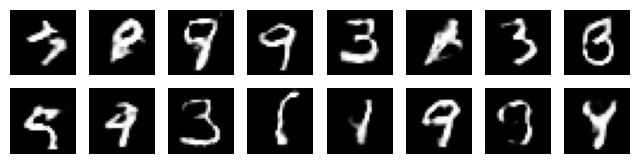

In [14]:

def discriminator_loss(y_true, y_pred):
    real_loss = cross_entropy(tf.ones_like(y_true), y_true)
    fake_loss = cross_entropy(tf.zeros_like(y_pred), y_pred)
    return real_loss + fake_loss

def generator_loss(y_pred):
    return cross_entropy(tf.ones_like(y_pred), y_pred)



@tf.function
def train_step(images):
    noise = tf.random.normal([CONFIG.num_examples, CONFIG.latent_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real = discriminator(images, training=True)
        fake = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake)
        disc_loss = discriminator_loss(real, fake)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))



def generate_and_save_images(model, epoch, t_input):
    generated_images = model(t_input)
    x = CONFIG.num_examples // 2
    y = CONFIG.num_examples - x
    figure = plt.figure(figsize=(x, y))

    for i in range(generated_images.shape[0]):
        plt.subplot(x, y, i+1)
        plt.imshow(generated_images[i, :, :, 0]*127.5 + 127.5, cmap="gray")
        plt.axis('off')
    plt.savefig(f"./images/img-epoch-{epoch}.png")
    plt.show()


num_train = train_images.shape[0]

def train(train_set, epochs = CONFIG.epochs):
    for epoch in range(1, epochs+1):
        display.clear_output(wait=True)
        print(f"Epoch [{epoch}/{epochs}]")
        pgb = Progbar(num_train)
        for batch in train_set:
            train_step(batch)
            pgb.add(CONFIG.batch_size)
        generate_and_save_images(generator, epoch, img_seed)

        if epoch % 20 == 0:
            checkpoint.save(file_prefix = ckpt_prefix)
    generate_and_save_images(generator, epoch, img_seed)


train(train_ds)

In [12]:
import os

for i in os.listdir():
  if i.endswith("png"):
    os.remove(f"{os.getcwd()}/{i}")

In [37]:
anim_file = 'dcgan.gif'
import imageio
from natsort import natsorted
import glob

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob("./images/img*.png")
  filenames = natsorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-37-290e24ca123a>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-37-290e24ca123a>:12: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



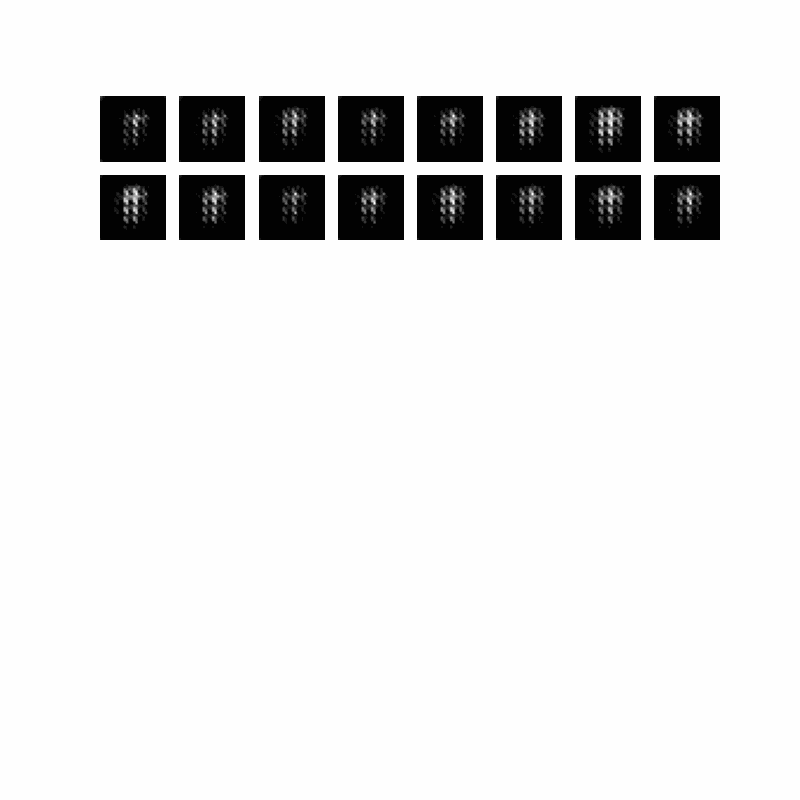

In [38]:
import tensorflow_docs.vis.embed as embed

embed.embed_file(anim_file)